# Frequency Subset Analysis for Modular Addition

Analyze output logits for neural network estimator:
$$\sum_{i=1}^m a \cdot \cos(\omega_k z + 2\phi) \cdot (\cos(\omega_k x + \phi) + \cos(\omega_k y + \phi))^2$$

where:
- $\omega_k = 2\pi k / p$
- $k \in \{1, 2, ..., (p-1)/2\}$
- $\phi \sim \text{Uniform}(0, 2\pi)$
- Neuron budget: 128, equally distributed across frequencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Parameters
p = 23  # Prime modulus (common choice for modular addition)
neuron_budget = 128
a = 1.0  # Amplitude

# Number of frequencies
num_freqs = (p - 1) // 2  # k = 1, 2, ..., (p-1)/2
print(f"Prime p = {p}")
print(f"Number of frequencies: {num_freqs}")
print(f"Neuron budget: {neuron_budget}")
print(f"Neurons per frequency: {neuron_budget / num_freqs:.2f}")

Prime p = 23
Number of frequencies: 11
Neuron budget: 128
Neurons per frequency: 11.64


In [3]:
# Distribute neurons equally across frequencies
neurons_per_freq = neuron_budget // num_freqs
remaining_neurons = neuron_budget % num_freqs

print(f"Base neurons per frequency: {neurons_per_freq}")
print(f"Remaining neurons to distribute: {remaining_neurons}")

# Create neuron assignment
neuron_counts = np.array([neurons_per_freq] * num_freqs)
# Distribute remaining neurons to first few frequencies
neuron_counts[:remaining_neurons] += 1

print(f"\nNeuron distribution for first 10 frequencies:")
for i in range(min(10, num_freqs)):
    print(f"  k={i+1}: {neuron_counts[i]} neurons")

Base neurons per frequency: 11
Remaining neurons to distribute: 7

Neuron distribution for first 10 frequencies:
  k=1: 12 neurons
  k=2: 12 neurons
  k=3: 12 neurons
  k=4: 12 neurons
  k=5: 12 neurons
  k=6: 12 neurons
  k=7: 12 neurons
  k=8: 11 neurons
  k=9: 11 neurons
  k=10: 11 neurons


In [4]:
def compute_logits_for_frequencies(x, y, freq_indices, neuron_counts, p, a=1.0):
    """
    Compute output logits for given (x, y) pair using specified frequencies.
    
    Args:
        x, y: Input values
        freq_indices: List of frequency indices k (1-indexed)
        neuron_counts: Array of neuron counts per frequency
        p: Prime modulus
        a: Amplitude
    
    Returns:
        logits: Array of shape (p,) with logit for each z
    """
    logits = np.zeros(p)
    
    for k_idx in freq_indices:
        k = k_idx  # k is 1-indexed
        omega_k = 2 * np.pi * k / p
        num_neurons = neuron_counts[k_idx - 1]
        
        # Deterministically choose phi uniformly from 0 to 2*pi
        phis = np.linspace(0, 2 * np.pi, num_neurons, endpoint=False)
        
        for phi in phis:
            # Compute contribution for each z
            for z in range(p):
                # f(x, y, z) = a * cos(w_k*z + 2*phi) * (cos(w_k*x + phi) + cos(w_k*y + phi))^2
                input_term = np.cos(omega_k * x + phi) + np.cos(omega_k * y + phi)
                output_term = np.cos(omega_k * z + 2 * phi)
                logits[z] += a * output_term * (input_term ** 2)
    
    return logits

In [5]:
def compute_logits_vectorized(x, y, freq_indices, neuron_counts, p, a=1.0):
    """
    Vectorized version for faster computation.
    Phases are deterministically chosen uniformly from 0 to 2*pi.
    """
    logits = np.zeros(p)
    z_vals = np.arange(p)
    
    for k_idx in freq_indices:
        k = k_idx
        omega_k = 2 * np.pi * k / p
        num_neurons = neuron_counts[k_idx - 1]
        
        # Deterministically choose phi uniformly from 0 to 2*pi
        phis = np.linspace(0, 2 * np.pi, num_neurons, endpoint=False)
        
        for phi in phis:
            input_term = np.cos(omega_k * x + phi) + np.cos(omega_k * y + phi)
            output_terms = np.cos(omega_k * z_vals + 2 * phi)
            logits += a * output_terms * (input_term ** 2)
    
    return logits

In [6]:
# Test case: x and y take values from 0 to p-1
x_test = 10
y_test = 12
z_true = (x_test + y_test) % p
print(f"Test case: x={x_test}, y={y_test}, z*={z_true}")
print(f"Valid range for x, y: 0 to {p-1}")

Test case: x=10, y=12, z*=22
Valid range for x, y: 0 to 22


In [7]:
# Define frequency subsets to analyze (dynamically based on num_freqs)
all_freqs = list(range(1, num_freqs + 1))

# Build subsets that respect the actual number of frequencies
frequency_subsets = {
    'Full': all_freqs,
}

# Add low frequency subsets
if num_freqs >= 3:
    frequency_subsets['Low (k=1-3)'] = list(range(1, 4))
if num_freqs >= 5:
    frequency_subsets['Low (k=1-5)'] = list(range(1, 6))

# Add mid-range subset (middle third of frequencies)
if num_freqs >= 6:
    mid_start = num_freqs // 3
    mid_end = 2 * num_freqs // 3
    frequency_subsets[f'Mid (k={mid_start}-{mid_end})'] = list(range(mid_start, mid_end + 1))

# Add high frequency subset (last few frequencies)
if num_freqs >= 3:
    high_start = max(1, num_freqs - 2)
    frequency_subsets[f'High (k={high_start}-{num_freqs})'] = list(range(high_start, num_freqs + 1))

# Add single frequency subsets
frequency_subsets['Single k=1'] = [1]
if num_freqs >= 2:
    mid_k = num_freqs // 2
    frequency_subsets[f'Single k={mid_k}'] = [mid_k]
if num_freqs >= 3:
    frequency_subsets[f'Single k={num_freqs}'] = [num_freqs]

# Add odd/even subsets
frequency_subsets['Odd k only'] = [k for k in all_freqs if k % 2 == 1]
frequency_subsets['Even k only'] = [k for k in all_freqs if k % 2 == 0]

print("Frequency subsets:")
for name, freqs in frequency_subsets.items():
    total_neurons = sum(neuron_counts[k-1] for k in freqs)
    print(f"  {name}: {len(freqs)} frequencies, {total_neurons} neurons")

Frequency subsets:
  Full: 11 frequencies, 128 neurons
  Low (k=1-3): 3 frequencies, 36 neurons
  Low (k=1-5): 5 frequencies, 60 neurons
  Mid (k=3-7): 5 frequencies, 60 neurons
  High (k=9-11): 3 frequencies, 33 neurons
  Single k=1: 1 frequencies, 12 neurons
  Single k=5: 1 frequencies, 12 neurons
  Single k=11: 1 frequencies, 11 neurons
  Odd k only: 6 frequencies, 70 neurons
  Even k only: 5 frequencies, 58 neurons


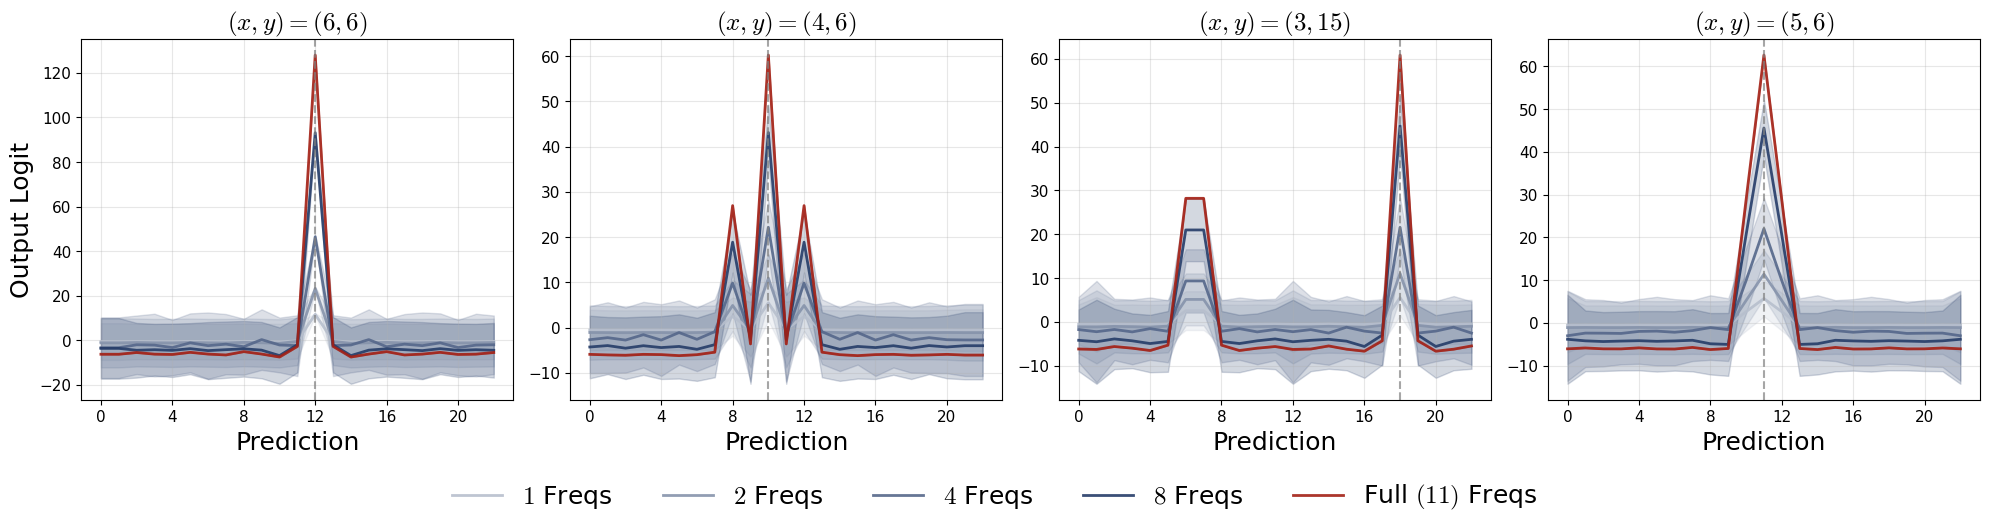

In [8]:
from itertools import combinations
import random
from matplotlib.colors import LinearSegmentedColormap

# Set matplotlib style to match reference
plt.rcParams['mathtext.fontset'] = 'cm'

def get_all_freq_combinations(num_freqs_to_select, total_freqs, max_combos=100):
    """Get all possible combinations of frequencies, limited to max_combos."""
    all_freqs = list(range(1, total_freqs + 1))
    all_combos = list(combinations(all_freqs, num_freqs_to_select))
    
    # If too many combinations, randomly sample
    if len(all_combos) > max_combos:
        random.seed(42)
        all_combos = random.sample(all_combos, max_combos)
    
    return all_combos

# Test pairs to analyze (use 4 pairs for square subplots)
test_pairs = [(6, 6), (4, 6), (3, 15), (5, 6)]
z_vals = np.arange(p)

# Number of frequencies to test
freq_counts = [1, 2, 4, 8, num_freqs]  # 1, 2, 4, 8, full
freq_labels = [r'$1$ Freqs', r'$2$ Freqs', r'$4$ Freqs', r'$8$ Freqs', rf'Full $({int((p-1)/2)})$ Freqs']

# Colors: white-blue gradient for non-diverse (1,2,4,8), red for diverse (full)
# Create custom colormap from white to blue
white_to_blue = LinearSegmentedColormap.from_list('white_blue', ['white', '#0D2758'], N=256)
colors_non_diverse = [white_to_blue(x) for x in np.linspace(0.3, 0.9, 4)]
colors = colors_non_diverse + ['#A32015']  # Add red for full frequencies

# Create 4 square subplots in a row
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Store legend handles and labels
legend_handles = []
legend_labels = []

for pair_idx, (x, y) in enumerate(test_pairs):
    ax = axes[pair_idx]
    z_true = (x + y) % p
    
    for fidx, (n_freq, label) in enumerate(zip(freq_counts, freq_labels)):
        # Get all combinations for this freq count (max 100)
        if n_freq == num_freqs:
            freq_combos = [tuple(range(1, num_freqs + 1))]
        else:
            freq_combos = get_all_freq_combinations(n_freq, num_freqs, max_combos=100)
        
        # Compute logits for all combinations
        all_logits = []
        for freq_combo in freq_combos:
            logits = compute_logits_vectorized(x, y, list(freq_combo), neuron_counts, p, a)
            all_logits.append(logits)
        
        all_logits = np.array(all_logits)
        mean_logits = np.mean(all_logits, axis=0)
        std_logits = np.std(all_logits, axis=0)
        
        # Plot mean with shading
        line, = ax.plot(z_vals, mean_logits, color=colors[fidx], linewidth=2, label=label, alpha=0.9)
        ax.fill_between(z_vals, mean_logits - std_logits, mean_logits + std_logits, 
                        color=colors[fidx], alpha=0.2)
        
        # Collect legend info from first subplot
        if pair_idx == 0:
            legend_handles.append(line)
            legend_labels.append(label)
    
    # Mark true z
    ax.axvline(x=z_true, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    
    ax.set_xlabel('Prediction', fontsize=18)
    # Only show y-label for first plot
    if pair_idx == 0:
        ax.set_ylabel('Output Logit', fontsize=18)
    ax.set_title(rf'$(x,y)=({x},{y})$', fontsize=18)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, p, 4))
    ax.tick_params(labelsize=11)
    ax.set_aspect('auto')

# Add single legend at the bottom center without box
fig.legend(legend_handles, legend_labels, loc='lower center', ncol=5, fontsize=18, 
          bbox_to_anchor=(0.5, -0.08), frameon=False)

# Adjust layout to make room for legend
plt.subplots_adjust(bottom=0.15)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('../figures/frequency_diversity_output_logits.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

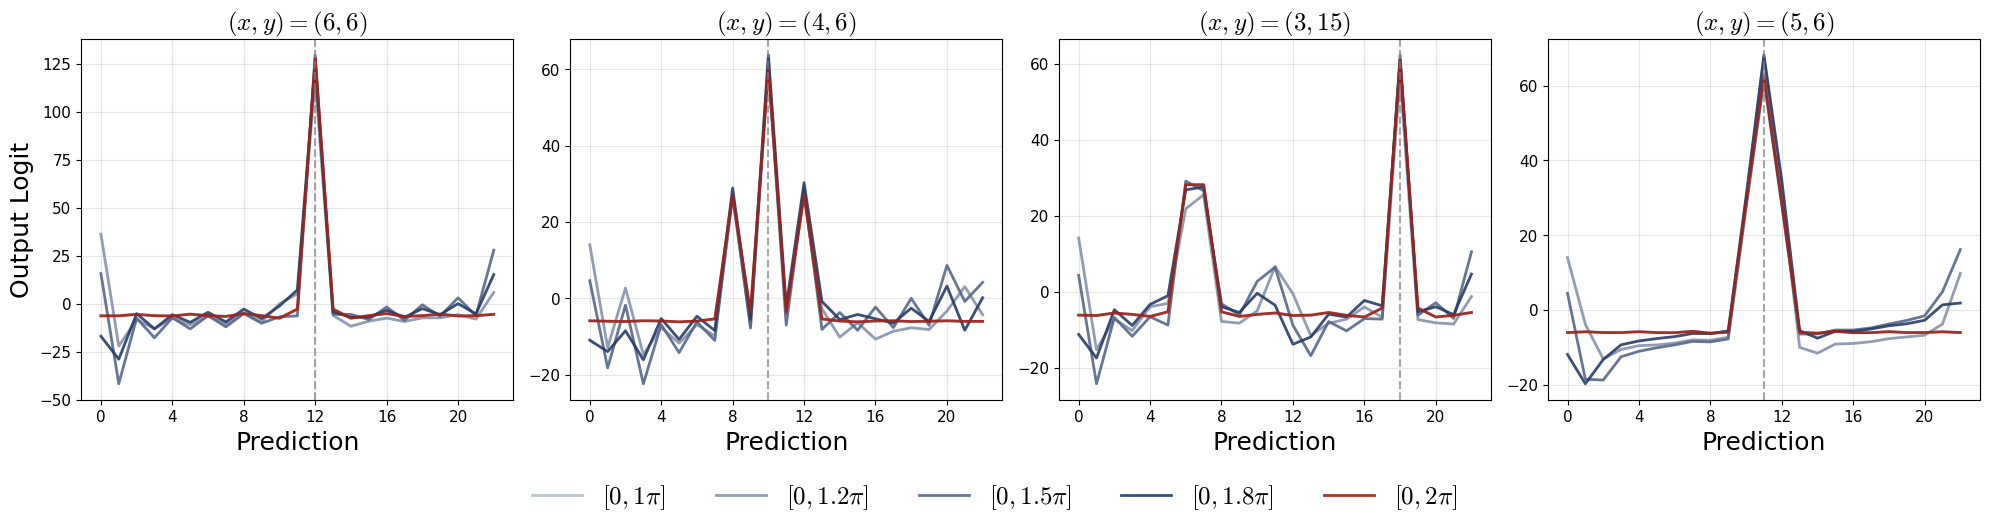

In [9]:
def compute_logits_with_phase_range(x, y, freq_indices, neuron_counts, p, phase_range, a=1.0):
    """
    Compute logits with phases uniformly distributed over [0, phase_range].
    
    Args:
        x, y: Input values
        freq_indices: List of frequency indices k (1-indexed)
        neuron_counts: Array of neuron counts per frequency
        p: Prime modulus
        phase_range: Maximum phase value (phases distributed from 0 to phase_range)
        a: Amplitude
    
    Returns:
        logits: Array of shape (p,) with logit for each z
    """
    logits = np.zeros(p)
    z_vals = np.arange(p)
    
    for k_idx in freq_indices:
        k = k_idx
        omega_k = 2 * np.pi * k / p
        num_neurons = neuron_counts[k_idx - 1]
        
        # Deterministically choose phi uniformly from 0 to phase_range
        phis = np.linspace(0, phase_range, num_neurons, endpoint=False)
        
        for phi in phis:
            input_term = np.cos(omega_k * x + phi) + np.cos(omega_k * y + phi)
            output_terms = np.cos(omega_k * z_vals + 2 * phi)
            logits += a * output_terms * (input_term ** 2)
    
    return logits

# Test pairs to analyze
test_pairs = [(6, 6), (4, 6), (3, 15), (5, 6)]
z_vals = np.arange(p)

# Generate phase ranges from π to 2π (so red is plotted last on top)
n_phase_ranges = 5
phase_multipliers = np.linspace(1, 2, n_phase_ranges)  # [1.0, 1.25, 1.5, 1.75, 2.0]
phase_ranges = phase_multipliers * np.pi
phase_labels = [rf'$[0, {mult:.2g}\pi]$' for mult in phase_multipliers]

# Colors: white-blue gradient for non-diverse phase ranges, red for diverse (2π)
white_to_blue = LinearSegmentedColormap.from_list('white_blue', ['white', '#0D2758'], N=256)
colors_non_diverse = [white_to_blue(x) for x in np.linspace(0.3, 0.9, 4)]
colors = colors_non_diverse + ['#A32015']  # Gradient first, then red for [0,2π] last

# Create 4 square subplots in a row
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Store legend handles and labels
legend_handles = []
legend_labels = []

# Use all frequencies for all cases
all_freq_indices = list(range(1, num_freqs + 1))

for pair_idx, (x, y) in enumerate(test_pairs):
    ax = axes[pair_idx]
    z_true = (x + y) % p
    
    for fidx, (phase_range, label) in enumerate(zip(phase_ranges, phase_labels)):
        # Compute logits with specified phase range
        logits = compute_logits_with_phase_range(x, y, all_freq_indices, neuron_counts, p, phase_range, a)
        
        # Plot
        line, = ax.plot(z_vals, logits, color=colors[fidx], linewidth=2, label=label, alpha=0.9)
        
        # Collect legend info from first subplot
        if pair_idx == 0:
            legend_handles.append(line)
            legend_labels.append(label)
    
    # Mark true z
    ax.axvline(x=z_true, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    
    ax.set_xlabel('Prediction', fontsize=18)
    # Only show y-label for first plot
    if pair_idx == 0:
        ax.set_ylabel('Output Logit', fontsize=18)
    ax.set_title(rf'$(x,y)=({x},{y})$', fontsize=18)
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, p, 4))
    ax.tick_params(labelsize=11)
    ax.set_aspect('auto')

# Add single legend at the bottom center without box
fig.legend(legend_handles, legend_labels, loc='lower center', ncol=5, fontsize=18, 
          bbox_to_anchor=(0.5, -0.08), frameon=False)

# Adjust layout to make room for legend
plt.subplots_adjust(bottom=0.15)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('../figures/phase_diversity_output_logits.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

# Ablation Study: Comprehensive Analysis

Compute P(correct) for all possible combinations and report statistics.

In [10]:
# Function to compute negative log probability (entropy loss)
def compute_entropy_loss(logits, z_true):
    """
    Compute negative log probability (cross-entropy loss) for the correct answer.
    
    Args:
        logits: Array of logits for each z
        z_true: True answer (index)
    
    Returns:
        neg_log_prob: Negative log probability of correct prediction
    """
    # Softmax (log-sum-exp trick for numerical stability)
    log_sum_exp = np.max(logits) + np.log(np.sum(np.exp(logits - np.max(logits))))
    log_prob_correct = logits[z_true] - log_sum_exp
    
    return -log_prob_correct

print("Function defined successfully!")

Function defined successfully!


## 1. Frequency Diversity Ablation: All Combinations

Test all possible frequency combinations and compute statistics for negative log probability (entropy loss).

In [11]:
import pandas as pd
from itertools import combinations

# Generate ALL (x,y) pairs for p=23
all_xy_pairs = [(x, y) for x in range(p) for y in range(p)]
print(f"Total (x,y) pairs to test: {len(all_xy_pairs)} (all combinations for p={p})")

# Frequency counts to test
freq_counts = [1, 2, 4, 8, num_freqs]

# Store results
results_freq = []

print("\nRunning frequency diversity ablation study...")
print("=" * 80)

for n_freq in freq_counts:
    print(f"\nTesting with {n_freq} frequencies:")
    
    # Get all combinations (or just the full set if n_freq == num_freqs)
    if n_freq == num_freqs:
        freq_combos = [tuple(range(1, num_freqs + 1))]
        print(f"  Using full frequency set: {len(freq_combos)} combination")
    else:
        # Get ALL combinations (not limited to 100)
        all_freqs = list(range(1, num_freqs + 1))
        freq_combos = list(combinations(all_freqs, n_freq))
        print(f"  Total frequency combinations: {len(freq_combos)}")
    
    # For each frequency combination, compute average loss over all (x,y) pairs
    combo_avg_losses = []
    
    for combo_idx, freq_combo in enumerate(freq_combos):
        # Compute loss for all (x,y) pairs for this frequency combination
        xy_losses = []
        
        for x, y in all_xy_pairs:
            z_true = (x + y) % p
            
            # Compute logits
            logits = compute_logits_vectorized(x, y, list(freq_combo), neuron_counts, p, a)
            
            # Compute entropy loss
            loss = compute_entropy_loss(logits, z_true)
            xy_losses.append(loss)
        
        # Average loss over all (x,y) pairs for this combination
        avg_loss_for_combo = np.mean(xy_losses)
        combo_avg_losses.append(avg_loss_for_combo)
        
        if (combo_idx + 1) % 20 == 0 or combo_idx == len(freq_combos) - 1:
            print(f"  Processed {combo_idx + 1}/{len(freq_combos)} combinations...")
    
    # Compute statistics over all combinations
    combo_avg_losses = np.array(combo_avg_losses)
    mean_of_avgs = np.mean(combo_avg_losses)
    median_of_avgs = np.median(combo_avg_losses)
    std_of_avgs = np.std(combo_avg_losses)
    
    results_freq.append({
        'n_frequencies': n_freq,
        'n_combinations': len(freq_combos),
        'n_xy_pairs': len(all_xy_pairs),
        'mean_loss': mean_of_avgs,
        'median_loss': median_of_avgs,
        'std_loss': std_of_avgs
    })
    
    print(f"  Mean of avg losses: {mean_of_avgs:.6f}")
    print(f"  Median of avg losses: {median_of_avgs:.6f}")
    print(f"  Std of avg losses: {std_of_avgs:.6f}")

print("\n" + "=" * 80)
print("Frequency Diversity Ablation - Summary Table:")
print("=" * 80)
df_freq = pd.DataFrame(results_freq)
print(df_freq.to_string(index=False))

Total (x,y) pairs to test: 529 (all combinations for p=23)

Running frequency diversity ablation study...

Testing with 1 frequencies:
  Total frequency combinations: 11
  Processed 11/11 combinations...
  Mean of avg losses: 1.642745
  Median of avg losses: 1.627571
  Std of avg losses: 0.020073

Testing with 2 frequencies:
  Total frequency combinations: 55
  Processed 20/55 combinations...
  Processed 40/55 combinations...
  Processed 55/55 combinations...
  Mean of avg losses: 0.602362
  Median of avg losses: 0.563451
  Std of avg losses: 0.087931

Testing with 4 frequencies:
  Total frequency combinations: 330
  Processed 20/330 combinations...
  Processed 40/330 combinations...
  Processed 60/330 combinations...
  Processed 80/330 combinations...
  Processed 100/330 combinations...
  Processed 120/330 combinations...
  Processed 140/330 combinations...
  Processed 160/330 combinations...
  Processed 180/330 combinations...
  Processed 200/330 combinations...
  Processed 220/330 c

## 2. Phase Diversity Ablation: All Test Pairs

Test different phase ranges and compute statistics for negative log probability (entropy loss).

In [12]:
# Phase ranges to test
n_phase_ranges = 6
phase_multipliers = np.linspace(0, 2, n_phase_ranges)[1:]  # [1.0, 1.25, 1.5, 1.75, 2.0]
phase_ranges = phase_multipliers * np.pi

# Use all frequencies for phase ablation
all_freq_indices = list(range(1, num_freqs + 1))

# Store results
results_phase = []

print("Running phase diversity ablation study...")
print("=" * 80)

for mult, phase_range in zip(phase_multipliers, phase_ranges):
    print(f"\nTesting with phase range [0, {mult:.2f}π]:")
    
    # Compute entropy loss for ALL (x,y) pairs
    all_losses = []
    
    for idx, (x, y) in enumerate(all_xy_pairs):
        z_true = (x + y) % p
        
        # Compute logits with specified phase range
        logits = compute_logits_with_phase_range(x, y, all_freq_indices, neuron_counts, p, phase_range, a)
        
        # Compute entropy loss
        loss = compute_entropy_loss(logits, z_true)
        all_losses.append(loss)
        
        if (idx + 1) % 100 == 0 or idx == len(all_xy_pairs) - 1:
            print(f"  Processed {idx + 1}/{len(all_xy_pairs)} (x,y) pairs...")
    
    # Compute statistics
    all_losses = np.array(all_losses)
    mean_loss = np.mean(all_losses)
    median_loss = np.median(all_losses)
    std_loss = np.std(all_losses)
    
    results_phase.append({
        'phase_range': f'[0, {mult:.2f}π]',
        'phase_multiplier': mult,
        'n_xy_pairs': len(all_xy_pairs),
        'mean_loss': mean_loss,
        'median_loss': median_loss,
        'std_loss': std_loss
    })
    
    print(f"  Mean loss: {mean_loss:.6f}")
    print(f"  Median loss: {median_loss:.6f}")
    print(f"  Std loss: {std_loss:.6f}")

print("\n" + "=" * 80)
print("Phase Diversity Ablation - Summary Table:")
print("=" * 80)
df_phase = pd.DataFrame(results_phase)
print(df_phase.to_string(index=False))

Running phase diversity ablation study...

Testing with phase range [0, 0.40π]:
  Processed 100/529 (x,y) pairs...
  Processed 200/529 (x,y) pairs...
  Processed 300/529 (x,y) pairs...
  Processed 400/529 (x,y) pairs...
  Processed 500/529 (x,y) pairs...
  Processed 529/529 (x,y) pairs...
  Mean loss: 4.815338
  Median loss: 0.005863
  Std loss: 10.164402

Testing with phase range [0, 0.80π]:
  Processed 100/529 (x,y) pairs...
  Processed 200/529 (x,y) pairs...
  Processed 300/529 (x,y) pairs...
  Processed 400/529 (x,y) pairs...
  Processed 500/529 (x,y) pairs...
  Processed 529/529 (x,y) pairs...
  Mean loss: 0.002001
  Median loss: 0.000000
  Std loss: 0.032476

Testing with phase range [0, 1.20π]:
  Processed 100/529 (x,y) pairs...
  Processed 200/529 (x,y) pairs...
  Processed 300/529 (x,y) pairs...
  Processed 400/529 (x,y) pairs...
  Processed 500/529 (x,y) pairs...
  Processed 529/529 (x,y) pairs...
  Mean loss: 0.000000
  Median loss: 0.000000
  Std loss: 0.000000

Testing wit

## Summary: Combined Statistics

Overview of both ablation studies with key findings.

In [13]:
print("=" * 80)
print("COMPREHENSIVE ABLATION STUDY SUMMARY")
print("=" * 80)

print("\n1. FREQUENCY DIVERSITY ABLATION:")
print("-" * 80)
print(f"{'N Freqs':<10} {'N Combos':<12} {'Mean Loss':<15} {'Median Loss':<16} {'Std Loss':<15}")
print("-" * 80)
for row in results_freq:
    print(f"{row['n_frequencies']:<10} {row['n_combinations']:<12} "
          f"{row['mean_loss']:<15.2e} {row['median_loss']:<16.2e} {row['std_loss']:<15.2e}")

print("\n2. PHASE DIVERSITY ABLATION:")
print("-" * 80)
print(f"{'Phase Range':<15} {'Mean Loss':<15}")
print("-" * 80)
for row in results_phase:
    print(f"{row['phase_range']:<15} {row['mean_loss']:<15.2e}")


COMPREHENSIVE ABLATION STUDY SUMMARY

1. FREQUENCY DIVERSITY ABLATION:
--------------------------------------------------------------------------------
N Freqs    N Combos     Mean Loss       Median Loss      Std Loss       
--------------------------------------------------------------------------------
1          11           1.64e+00        1.63e+00         2.01e-02       
2          55           6.02e-01        5.63e-01         8.79e-02       
4          330          2.88e-02        2.62e-02         1.55e-02       
8          165          2.99e-08        1.74e-09         1.07e-07       
11         1            7.41e-15        7.41e-15         0.00e+00       

2. PHASE DIVERSITY ABLATION:
--------------------------------------------------------------------------------
Phase Range     Mean Loss      
--------------------------------------------------------------------------------
[0, 0.40π]      4.82e+00       
[0, 0.80π]      2.00e-03       
[0, 1.20π]      1.19e-09       
[0, 1.60π